# Assignment 3: Use a single feature with different models

### Load full SVHN from HugginFace

In [119]:
# Import hugging face dataset
import huggingface_hub
from datasets import load_dataset

# Import cropped-digits dataset
dataset_cropped_digits_raw = load_dataset("ufldl-stanford/svhn", "cropped_digits")

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2

from skimage import color, exposure, filters, util, morphology
from skimage import img_as_ubyte, img_as_float
from skimage.filters import rank
from skimage.filters import gaussian
from sklearn.preprocessing import FunctionTransformer

In [121]:
# Get dataset subsets
ds_train = dataset_cropped_digits_raw["train"]
ds_test = dataset_cropped_digits_raw["test"]

### Functions and pipeline

In [122]:
def apply_gaussian_filter(image, sigma=6):
    # Create a Gaussian mask based on distance from the center
    height, width = image.shape
    y, x = np.ogrid[:height, :width]
    center_y, center_x = height / 2, width / 2

    # Create a Gaussian mask
    # sigma = Standard deviation for the Gaussian function
    mask = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))

    # Apply the Gaussian mask to the image
    masked_image = image * mask

    # Scale the masked image to 0-255
    masked_image_scaled = (masked_image - np.min(masked_image)) / (np.max(masked_image) - np.min(masked_image)) * 255
    masked_image_scaled = masked_image_scaled.astype(np.uint8)

    return masked_image_scaled, mask

def remove_borders(image, reduce_factor=0.1):
    # Define the border width as 10% of the image size
    border_size = int(32 * reduce_factor)

    blackout_image = image.copy()
    # Set the border regions to black (0)
    # Top border
    blackout_image[:border_size, :] = 0
    # Bottom border
    blackout_image[-border_size:, :] = 0
    # Left border
    blackout_image[:, :border_size] = 0
    # Right border
    blackout_image[:, -border_size:] = 0

    return blackout_image

def find_contours(image):
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Create a blank image to draw contours on
    contour_only_image = np.zeros_like(image)
    cv2.drawContours(contour_only_image, contours, -1, 255, 1)  # Draw contours in white (255)
    return contour_only_image

def sharpen_image(image, filter=(5,5)):
    # Sharpen image
    blurred = cv2.GaussianBlur(image, filter, 0)
    return cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

def apply_median_filter(image):
    # Step 2: Reduce the impact of outliers using median filter
    selem = morphology.disk(2)
    return filters.rank.median(img_as_ubyte(image), selem)

def apply_log_filter(image):
    # Create a FunctionTransformer for the log transformation
    log_transformer = FunctionTransformer(np.log1p, validate=True)

    # Apply the log transformation
    transformed_image = log_transformer.fit_transform(image)

    # Rescale the transformed image back to [0, 255]
    transformed_image = (transformed_image / np.max(transformed_image)) * 255
    return transformed_image.astype(np.uint8)

In [193]:
def pipeline(ds,
             labels_ds,
             clahe_clipLimit=2.0,
             clahe_tileGridSize=(3,3),
             sharpen_filter=(5,5),
             gaussian_sigma=6,
             extra_filter=None,
             random_sample_id= None
             ):
    """ 
    Assumes input dataset are N samples of RGB images, 32x32 (32, 32, 3) shape.
    Input must be a np-array with images only.
    Transforms from RGB (3-channels) to a single grayscale channel
    Applies Gaussian weighting to remove distractions in borders
    Actual digit is centered

    Returns modified dataset
    """
    # Initialize an array to hold the grayscale images
    new_dataset = np.empty((len(ds), 32, 32), dtype=np.uint8)

    if random_sample_id is None:
        random_sample_id = random.randint(0, len(ds))
    original_random_image = ds[random_sample_id]
    original_random_label = labels_ds[random_sample_id]

    # Step 1: Convert images to grayscale
    gray_images = (color.rgb2gray(ds) * 255).astype(np.uint8)

    # Iterate per-image
    total_images_processed = 0
    for i in range(0, len(gray_images)):
        
        total_images_processed +=1
        gray_image = gray_images[i]

        # Sharpening
        sharpened_image = sharpen_image(gray_image, sharpen_filter)

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=clahe_clipLimit, tileGridSize=clahe_tileGridSize)
        clahe_image = clahe.apply(sharpened_image)

        # Median filter
        median_filtered_image = apply_median_filter(clahe_image)

        # Log filter
        log_filtered_image = apply_log_filter(clahe_image)

        image_for_binary = clahe_image
        if (extra_filter=="log"):
            image_for_binary = log_filtered_image
        if (extra_filter==None):
            image_for_binary = median_filtered_image

        # Use binary threshold to reduce everything to 2 colors
        _, binary_image = cv2.threshold(image_for_binary, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        print(f'mean_binary: {np.mean(binary_image)}')

        # Get contours
        contour_image = find_contours(binary_image)

        # Gaussian filter
        masked_image_scaled, mask = apply_gaussian_filter(contour_image, gaussian_sigma)

        new_dataset[i] = masked_image_scaled

        # Log filter
        # log_filtered_image = apply_log_filter(median_filtered_image)

        if i == random_sample_id:
            # Visualization of the steps
            fig, axes = plt.subplots(1, 9, figsize=(18, 6))

            # Plot each image
            axes[0].imshow(original_random_image, cmap='gray')
            axes[0].set_title("Original Image")
            axes[0].axis('off')

            axes[1].imshow(gray_image, cmap='gray')
            axes[1].set_title("Grayscale Image")
            axes[1].axis('off')

            axes[2].imshow(sharpened_image, cmap='gray')
            axes[2].set_title("Sharpening")
            axes[2].axis('off')

            axes[3].imshow(clahe_image, cmap='gray')
            axes[3].set_title("CLAHE")
            axes[3].axis('off')

            axes[4].imshow(image_for_binary, cmap='gray')
            axes[4].set_title("CLAHE + Extra filtering")
            axes[4].axis('off')

            axes[5].imshow(binary_image, cmap='gray')
            axes[5].set_title("Dynamic Thresholding")
            axes[5].axis('off')

            axes[6].imshow(contour_image, cmap='gray')
            axes[6].set_title("Contours")
            axes[6].axis('off')

            axes[7].imshow(mask, cmap='gray')
            axes[7].set_title("Gaussian filter")
            axes[7].axis('off')

            axes[8].imshow(masked_image_scaled, cmap='gray')
            axes[8].set_title("Masked image")
            axes[8].axis('off')

            #
            #axes[5].imshow(log_filtered_image, cmap='gray')
            #axes[5].set_title("Median + log Image")
            #axes[5].axis('off')

            plt.suptitle(f'Label: {original_random_label}, index:{random_sample_id}', fontsize=16)

            # Adjust spacing between subplots
            plt.subplots_adjust(wspace=0.3)

            plt.tight_layout()
            plt.show()

    return new_dataset

#### Simple testing

In [194]:
#Interesting: 3, 5, 13, 1082, 1300, 21490, 28689, 26051, 28689, 41470

index = 26051
image = np.array(ds_train[index]["image"])

mean_binary: 197.4755859375


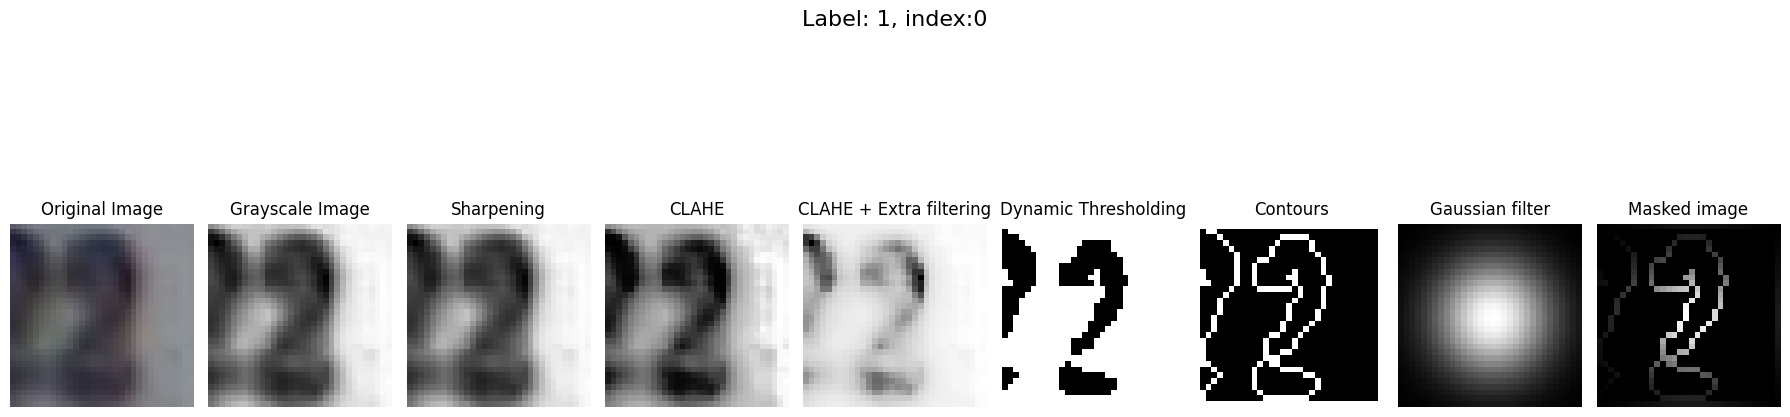

In [195]:

test = pipeline(np.expand_dims(image, axis=0),
                ds_train["label"],
                clahe_clipLimit=-100,
                clahe_tileGridSize=(1,1),
                sharpen_filter=(1,1),
                gaussian_sigma=7,
                extra_filter="log",
                random_sample_id=0)

In [196]:
#chatgpt
def binary_threshold(image, threshold):
    return np.where(image > threshold, 255, 0).astype(np.uint8)

def test():
    # Step 1: Convert image to grayscale
    gray_image = (color.rgb2gray(image) * 255).astype(np.uint8)

    # Sharpening
    sharpened_image = sharpen_image(gray_image)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1, 1))
    clahe_image = clahe.apply(gray_image)

    # Apply sharpening on CLAHE result
    # Define a sharpening kernel
    #sharpen_kernel = np.array([[0, -1, 0],
    #                           [-1, 5, -1],
    #                           [0, -1, 0]])
    #sharpened_clahe_image = cv2.filter2D(clahe_image, -1, sharpen_kernel)
    sharpened_clahe_image = clahe_image

    # Median filter
    median_filtered_image = apply_median_filter(sharpened_clahe_image)
    # Log filter
    log_filtered_image = apply_log_filter(median_filtered_image)

    # Use binary threshold to reduce everything to 2 colors

    _, binary_image = cv2.threshold(sharpened_clahe_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    contour_image = find_contours(binary_image)

    # Gaussian filter
    masked_image_scaled, mask = apply_gaussian_filter(contour_image)

    # Visualization of the steps
    fig, axes = plt.subplots(1, 9, figsize=(18, 6))

    # Plot each image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(gray_image, cmap='gray')
    axes[1].set_title("Grayscale Image")
    axes[1].axis('off')

    axes[2].imshow(sharpened_image, cmap='gray')
    axes[2].set_title("Sharpening")
    axes[2].axis('off')

    axes[3].imshow(clahe_image, cmap='gray')
    axes[3].set_title("CLAHE")
    axes[3].axis('off')

    axes[4].imshow(median_filtered_image, cmap='gray')
    axes[4].set_title("CLAHE + Median filtering")
    axes[4].axis('off')

    axes[5].imshow(binary_image, cmap='gray')
    axes[5].set_title("Dynamic Thresholding")
    axes[5].axis('off')

    axes[6].imshow(contour_image, cmap='gray')
    axes[6].set_title("Contours")
    axes[6].axis('off')

    axes[7].imshow(mask, cmap='gray')
    axes[7].set_title("Gaussian filter")
    axes[7].axis('off')

    axes[8].imshow(masked_image_scaled, cmap='gray')
    axes[8].set_title("Masked Image with Gaussian filter")
    axes[8].axis('off')

    #
    #axes[5].imshow(log_filtered_image, cmap='gray')
    #axes[5].set_title("Median + log Image")
    #axes[5].axis('off')

    plt.suptitle(f'Label: {ds_train[index]["label"]}', fontsize=16)

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3)

    plt.tight_layout()
    plt.show()

## Get X_train, X_test datasets with our processing

mean_binary: 117.7880859375
mean_binary: 122.7685546875
mean_binary: 125.5078125
mean_binary: 121.025390625
mean_binary: 131.7333984375
mean_binary: 125.2587890625
mean_binary: 123.2666015625
mean_binary: 121.2744140625
mean_binary: 131.7333984375
mean_binary: 129.4921875
mean_binary: 124.51171875
mean_binary: 127.5
mean_binary: 130.986328125
mean_binary: 120.7763671875
mean_binary: 128.2470703125
mean_binary: 130.986328125
mean_binary: 126.50390625
mean_binary: 132.48046875
mean_binary: 129.2431640625
mean_binary: 132.7294921875
mean_binary: 134.47265625
mean_binary: 131.982421875
mean_binary: 122.2705078125
mean_binary: 118.2861328125
mean_binary: 128.994140625
mean_binary: 127.998046875
mean_binary: 112.060546875
mean_binary: 122.021484375
mean_binary: 122.021484375
mean_binary: 121.025390625
mean_binary: 126.7529296875
mean_binary: 121.2744140625
mean_binary: 132.48046875
mean_binary: 128.994140625
mean_binary: 125.5078125
mean_binary: 127.998046875
mean_binary: 143.6865234375
mean

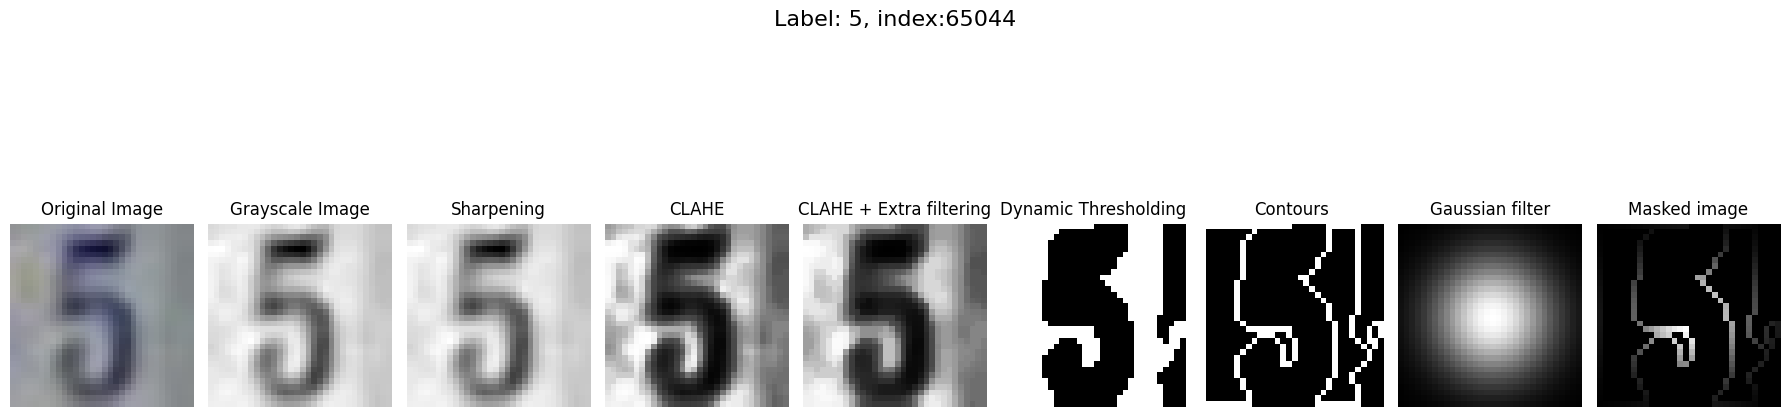

mean_binary: 125.009765625
mean_binary: 126.50390625
mean_binary: 123.2666015625
mean_binary: 127.998046875
mean_binary: 127.2509765625
mean_binary: 134.47265625
mean_binary: 133.2275390625
mean_binary: 125.2587890625
mean_binary: 123.515625
mean_binary: 118.037109375
mean_binary: 119.033203125
mean_binary: 119.53125
mean_binary: 112.060546875
mean_binary: 118.53515625
mean_binary: 110.56640625
mean_binary: 102.59765625
mean_binary: 118.037109375
mean_binary: 117.7880859375
mean_binary: 132.7294921875
mean_binary: 139.453125
mean_binary: 127.7490234375
mean_binary: 129.7412109375
mean_binary: 119.53125
mean_binary: 122.7685546875
mean_binary: 124.013671875
mean_binary: 133.2275390625
mean_binary: 136.46484375
mean_binary: 124.7607421875
mean_binary: 126.005859375
mean_binary: 125.2587890625
mean_binary: 124.013671875
mean_binary: 128.49609375
mean_binary: 132.2314453125
mean_binary: 117.041015625
mean_binary: 126.50390625
mean_binary: 127.2509765625
mean_binary: 124.7607421875
mean_bin

In [197]:
# X_train

ds_train_images = np.array(ds_train["image"])
X_train = pipeline(ds_train_images,
                   ds_train["label"],
                   clahe_clipLimit=-1,
                   clahe_tileGridSize=(1,1),
                   sharpen_filter=(1,1),
                   gaussian_sigma=7,
                   extra_filter=None
                   )
Y_train = ds_train["label"]

X_train = X_train.reshape(X_train.shape[0], -1)

print(X_train.shape)

mean_binary: 136.46484375
mean_binary: 129.990234375
mean_binary: 123.515625
mean_binary: 126.50390625
mean_binary: 119.7802734375
mean_binary: 130.2392578125
mean_binary: 120.52734375
mean_binary: 135.46875
mean_binary: 127.998046875
mean_binary: 117.5390625
mean_binary: 122.021484375
mean_binary: 127.998046875
mean_binary: 127.5
mean_binary: 133.7255859375
mean_binary: 131.982421875
mean_binary: 142.6904296875
mean_binary: 130.986328125
mean_binary: 129.2431640625
mean_binary: 119.2822265625
mean_binary: 126.005859375
mean_binary: 124.7607421875
mean_binary: 121.025390625
mean_binary: 135.7177734375
mean_binary: 132.2314453125
mean_binary: 128.2470703125
mean_binary: 126.005859375
mean_binary: 151.40625
mean_binary: 123.7646484375
mean_binary: 129.990234375
mean_binary: 126.005859375
mean_binary: 127.001953125
mean_binary: 131.2353515625
mean_binary: 128.2470703125
mean_binary: 114.3017578125
mean_binary: 112.3095703125
mean_binary: 128.994140625
mean_binary: 121.025390625
mean_binar

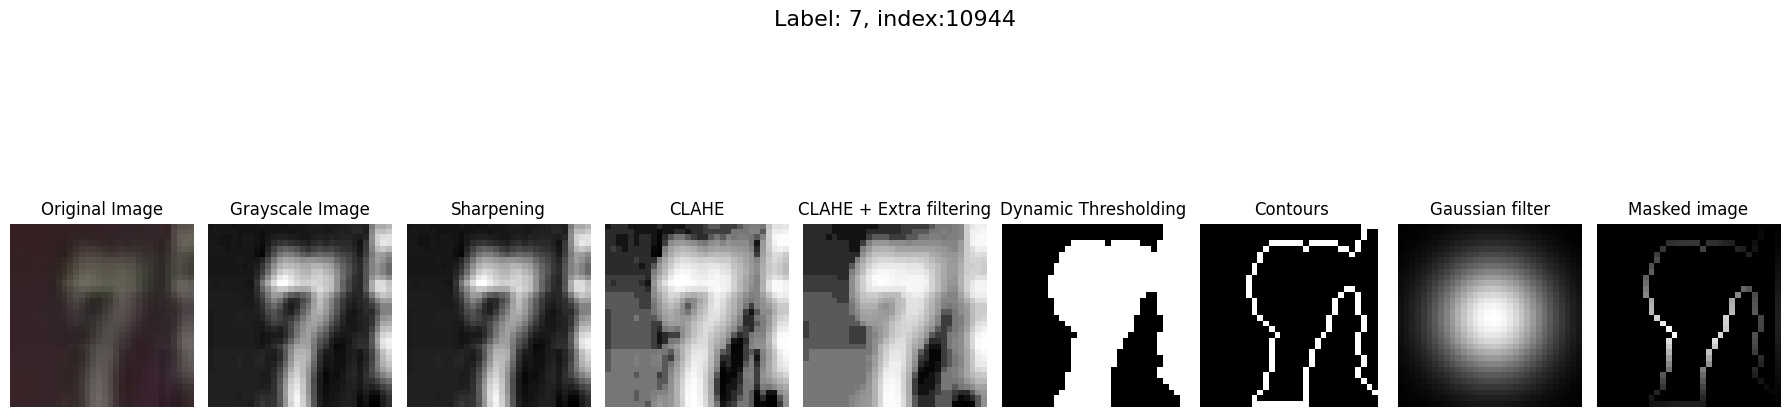

mean_binary: 123.017578125
mean_binary: 125.009765625
mean_binary: 124.51171875
mean_binary: 119.53125
mean_binary: 119.2822265625
mean_binary: 120.2783203125
mean_binary: 129.990234375
mean_binary: 131.982421875
mean_binary: 130.986328125
mean_binary: 179.296875
mean_binary: 127.2509765625
mean_binary: 123.2666015625
mean_binary: 120.2783203125
mean_binary: 125.2587890625
mean_binary: 126.50390625
mean_binary: 128.49609375
mean_binary: 135.46875
mean_binary: 129.2431640625
mean_binary: 131.484375
mean_binary: 123.2666015625
mean_binary: 131.982421875
mean_binary: 125.2587890625
mean_binary: 128.49609375
mean_binary: 125.2587890625
mean_binary: 124.7607421875
mean_binary: 118.53515625
mean_binary: 125.009765625
mean_binary: 117.041015625
mean_binary: 128.7451171875
mean_binary: 129.2431640625
mean_binary: 130.2392578125
mean_binary: 127.7490234375
mean_binary: 135.2197265625
mean_binary: 130.2392578125
mean_binary: 121.025390625
mean_binary: 132.7294921875
mean_binary: 156.884765625
me

In [198]:
# X_test

ds_test_images = np.array(ds_test["image"])
X_test = pipeline(ds_test_images,
                  ds_test["label"],
                  clahe_clipLimit=(-1),
                  clahe_tileGridSize=(1,1),
                  sharpen_filter=(1,1),
                  gaussian_sigma=7,
                  extra_filter=None
                 )
Y_test = ds_test["label"]

X_test = X_test.reshape(X_test.shape[0], -1)

print(X_test.shape)

## Use PCA

In [199]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_surprise = pca.fit_transform(X_train)
X_surprise.shape

(73257, 2)

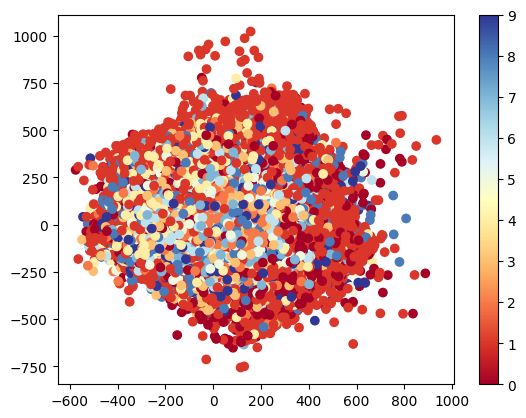

In [200]:
plt.scatter(X_surprise[:, 0], X_surprise[:, 1], c=np.array(ds_train["label"]), cmap='RdYlBu')
plt.colorbar()

### Run with SKLEARN LogisticRegression

In [201]:
## Use SGDC for clasification
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
#
#model = SGDClassifier(alpha=0.001, max_iter=1000)
#model.fit(X_train, Y_train)
#
#y_pred = model.predict(X_test)
#
#accuracy = accuracy_score(Y_test, y_pred)
#print(f"Accuracy: {accuracy:.4f}")

### Run with cross validation

In [202]:
from sklearn.model_selection import GridSearchCV

#parameters = {
#    'alpha'    : [0.001, 0.01, 0.1],
#    'max_iter' : [1000]
#}
#
#model = SGDClassifier()
#gridsearch = GridSearchCV(estimator=model,
#                          param_grid=parameters,
#                          n_jobs=2)
#gridsearch.fit(X_train, Y_train)

In [ ]:
model = SGDClassifier(alpha=0.1,
                      max_iter=1000)

model.fit(X_train, Y_train)
model.score(X_test, Y_test)

In [ ]:
#from sklearn.linear_model import LogisticRegression
#
#log_reg = LogisticRegression(max_iter=1000)
#
#log_reg.fit(X_train, Y_train)
#
#y_pred = log_reg.predict(X_test)
#
#accuracy = accuracy_score(Y_test, y_pred)
#print(f"Accuracy: {accuracy:.4f}")